## Data preparation using Numpy/Pandas by Changik Choi
*** 

In [1]:
# Importing library
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import datetime
# Quick look
rides=pd.read_csv('data/train.csv')
# Extract 'month' and 'hour' features from 'datetime'
rides.datetime = rides.datetime.apply(pd.to_datetime)
rides['month'] = rides.datetime.apply(lambda x: x.month)
rides['hour'] = rides.datetime.apply(lambda x : x.hour)
rides.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


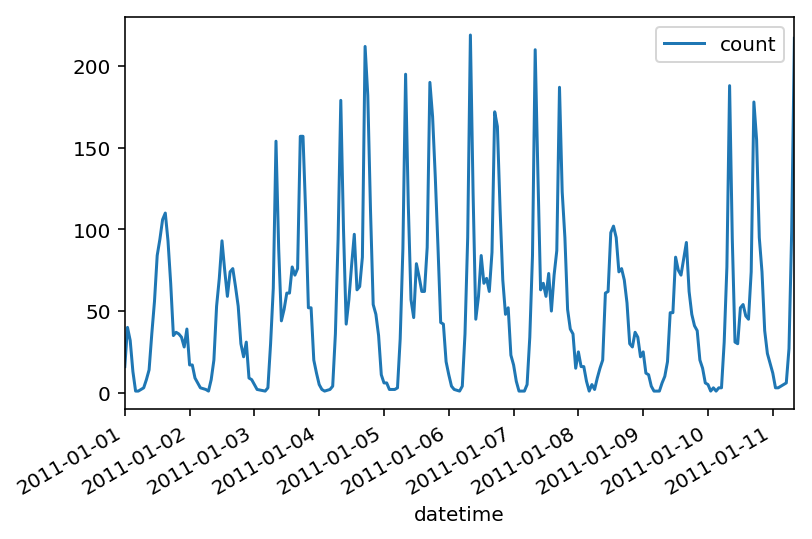

In [3]:
# First 30 days
rides[:24*10].plot(x='datetime', y='count')

In [4]:
# Apply "One Hot Encoding" on categorical variables
# You can use "pandas.get_dummies" library
dummy_fields = ['season', 'weather', 'workingday', 'holiday', 'hour', 'month']
for field in dummy_fields:
    dummy = pd.get_dummies(rides[field], prefix=field, drop_first=False)
    rides = pd.concat([rides, dummy], axis=1)

In [5]:
# Drop off some fields we don't need
drop_fields = ['datetime', 'season', 'weather', 'workingday', 'holiday', 'registered', 'casual', 'atemp', 'hour', 'month']
data = rides.drop(drop_fields, axis=1)
print (data.columns)

Index(['temp', 'humidity', 'windspeed', 'count', 'season_1', 'season_2',
       'season_3', 'season_4', 'weather_1', 'weather_2', 'weather_3',
       'weather_4', 'workingday_0', 'workingday_1', 'holiday_0', 'holiday_1',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


In [6]:
# Normalize the data.
# To get a higher accuracy, we need to normalized on its continous variable
# That is, each continous variable fields will have zero mean and standard deviation of 1
quant_features = ['count', 'temp', 'humidity', 'windspeed']
# We will need this mean/std for later !
# store scalings in a dictionary
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [7]:
# Shuffle the data, and split into train and validation set
[train, valid] = train_test_split(data, test_size = 0.10)
# Quick check how does data look like now
print ("Train: {}\t Valid: {}".format(train.shape, valid.shape))

Train: (9797, 52)	 Valid: (1089, 52)


In [8]:
# Seperate our inputs(features) and output(target)
train_inputs, train_outputs = train.drop('count', axis=1), train['count']
valid_inputs, valid_outputs = valid.drop('count', axis=1), valid['count']
# Quick check how does data look like now
print ("Train Inputs: {}\t Train Outputs: {}".format(train_inputs.shape, train_outputs.shape))
print ("Valid Inputs: {}\t Valid Outputs: {}".format(valid_inputs.shape, valid_outputs.shape))

Train Inputs: (9797, 51)	 Train Outputs: (9797,)
Valid Inputs: (1089, 51)	 Valid Outputs: (1089,)


## Data preparation is done !
*** 

***
## Build Neural Network from Scratch !
### Don't forget to run codes from part_1 if you restarted kernel !

In [9]:
class NeuralNetwork(object):
    # Define structure of NN, create placeholders
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Setting number of nodes
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        
        # Setting initial weights
        #np.random.normal(mean, sd, size)
        self.weights_input_hidden = np.random.normal(0.0,
                                                     self.input_nodes ** -0.5,
                                                    (self.input_nodes,self.hidden_nodes))
        self.weights_hidden_output = np.random.normal(0.0,
                                                     self.hidden_nodes ** -0.5,
                                                    (self.hidden_nodes,self.output_nodes))
        # sigmoid function
        self.sigmoid = lambda x : 1 / (1 + np.exp(-x))
    
    # Forward pass / Backward pass / Weights updates
    def train(self, features, targets):
        n_records = features.shape[0]
        # Set placeholder for weight changes
        delta_weights_input_hidden = np.zeros(self.weights_input_hidden.shape)
        delta_weights_hidden_output = np.zeros(self.weights_hidden_output.shape)
        
        # Forward/Backward pass for each records
        for X, y in zip(features, targets):
            ## Forward pass - input-hidden
            hidden_inputs = np.dot(X, self.weights_input_hidden)
            hidden_outputs = self.sigmoid(hidden_inputs)
            
            ## Forward pass - hidden-output
            outputs= np.dot(hidden_outputs, self.weights_hidden_output)
            
            ## Backward pass
            #  Caclulate error on each layers
            error = y - outputs
            hidden_error = np.dot(self.weights_hidden_output, error)
            
            # Calculate errors_term for each layer
            output_error_term = error # derivative of 'f(x) = x' is '1'
            # The node in hidden layer with bigger weights has bigger "impact" on output 
            # which means has bigger contribution on "error"
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            
            ## stack the weight steps 
            delta_weights_input_hidden += hidden_error_term * X[:, None]
            delta_weights_hidden_output += output_error_term * hidden_outputs[:, None]
        
        # Gradient descent, update weights
        self.weights_input_hidden += self.learning_rate * delta_weights_input_hidden / n_records
        self.weights_hidden_output += self.learning_rate * delta_weights_hidden_output / n_records
    
    # Returns prediction using input
    def run(self, features):
        # Run forward pass, returns predict y value 
        hidden_inputs = np.dot(features, self.weights_input_hidden)
        hidden_outputs = self.sigmoid(hidden_inputs)
        
        outputs = np.dot(hidden_outputs, self.weights_hidden_output)
        return outputs                                                     

In [10]:
# Returns 'Mean Squared Error'
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [11]:
import sys

### Set the hyperparameters here ###
iterations = 6000
learning_rate =  0.01
hidden_nodes = 32
output_nodes = 1

input_nodes = train_inputs.shape[1]
network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_inputs.index, size=128)
    X, y = train_inputs.loc[batch].values, train_outputs.loc[batch]
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_inputs).T, train_outputs.values)
    val_loss = MSE(network.run(valid_inputs).T, valid_outputs.values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.470 ... Validation loss: 0.519

## Let's see how does our model's prediction look like.


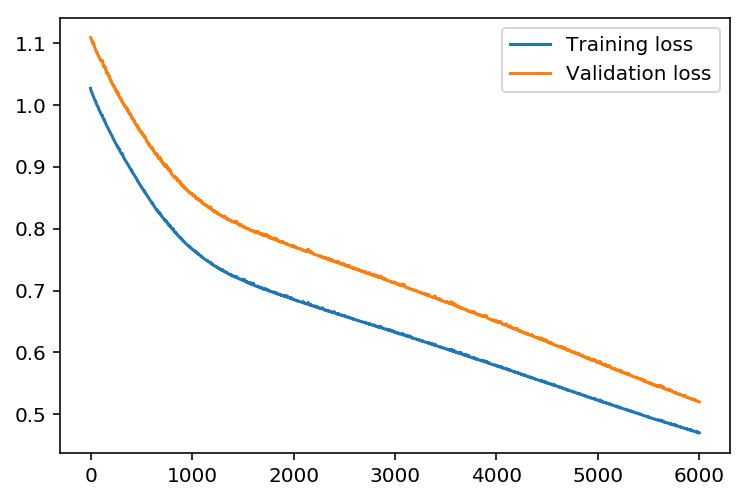

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

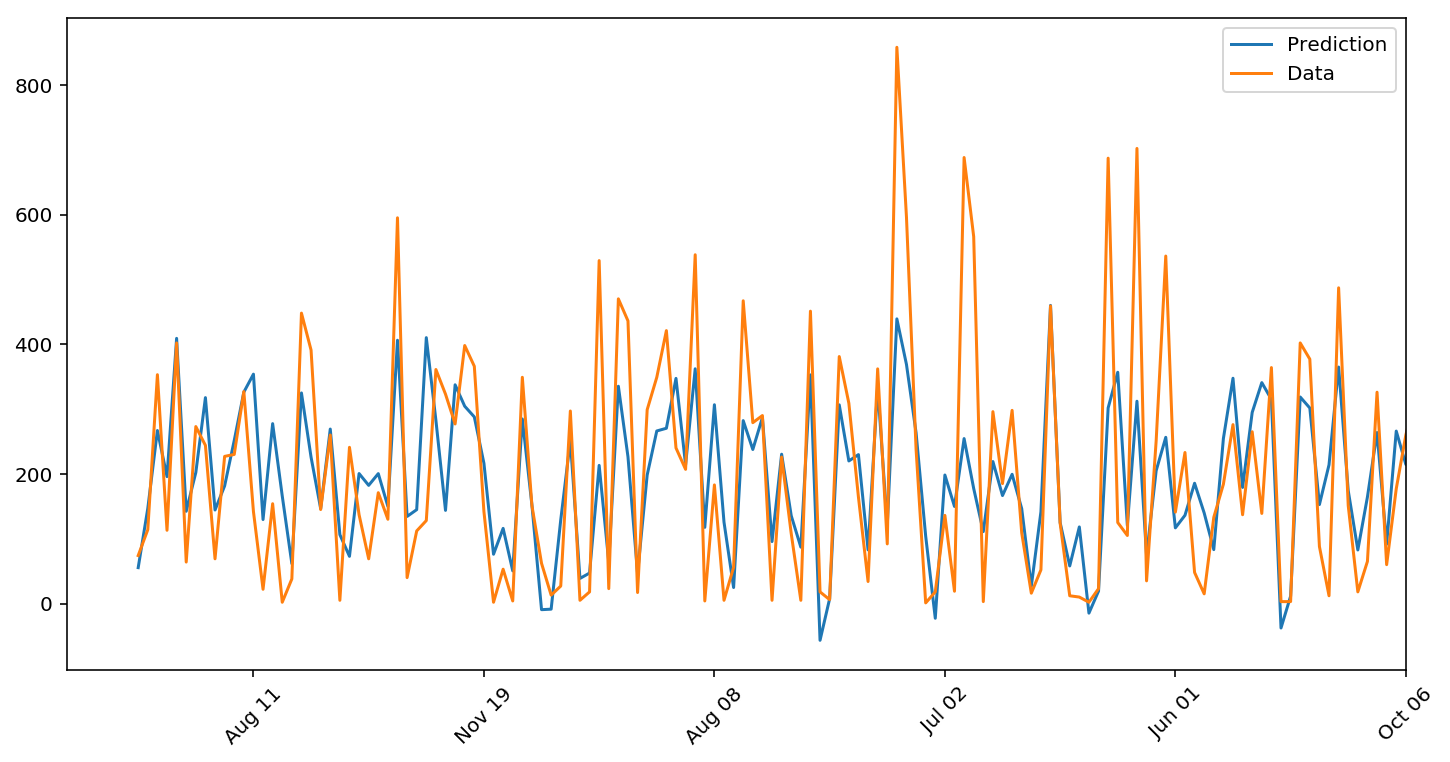

In [13]:
# Let's plot our first 150 data points 
fig, ax = plt.subplots(figsize=(12,6))
mean, std = scaled_features['count']
predictions = network.run(valid_inputs).T*std + mean
ax.plot(predictions[0][:150], label='Prediction')
ax.plot((valid_outputs*std + mean).values[:150], label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.loc[valid_outputs.index[:150]]['datetime'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Result looks good !
x-axis seems bit odd,  it is because we shuffle the data when we split data into  train/valid sets
***

## Actual prediction on 'Test' data set using the model we trained & submit on Kaggle
### Don't forget to run codes from part_1, part_2 if you restarted kernel !
*** 

We are going to do exactly same data-prep we did on part_1 with 'Test' data 

In [14]:
# load test data
test = pd.read_csv('data/test.csv')

In [15]:
# extract month, and hour features from datetime
test.datetime = test.datetime.apply(pd.to_datetime)
test['month'] = test.datetime.apply(lambda x: x.month)
test['hour'] = test.datetime.apply(lambda x : x.hour)

In [16]:
# Apply One-Hot-Encoding
dummy_fields = ['season', 'weather', 'workingday', 'holiday', 'hour', 'month']
for field in dummy_fields:
    dummy = pd.get_dummies(test[field], prefix=field, drop_first=False)
    test = pd.concat([test, dummy], axis=1)
# Drop the fields we don't need
drop_fields = ['datetime', 'season', 'weather', 'workingday', 'holiday', 'atemp', 'hour', 'month']
test = test.drop(drop_fields, axis=1)

In [17]:
# Normalize continuous variable
# Remember, we use mean/std from 'Train' data, not 'Test' data
test_quant_features = ['temp', 'humidity', 'windspeed']
for each in test_quant_features:
    mean, std = scaled_features[each]
    test.loc[:, each] = (test[each] - mean)/std

In [18]:
# Calculate Prediction using 'Test' data
mean, std = scaled_features['count']
test_predict = network.run(test).T*std + mean

In [19]:
submit = pd.read_csv('data/test.csv')
submit['count'] = test_predict.T
submit = submit[['datetime', 'count']]
# There are some negative prediction values which Kaggle does not accept as prediction 
# We will replace those with zeros
submit['count'].loc[submit['count'] < 0] = 0
# Save the result as csv file
submit.to_csv('submit.csv', index=False)

## Alright, ready to submit !
***